In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df_train = pd.read_csv(r"C:\Users\Asad shaikh\Documents\Titanic_train.csv")
df_test = pd.read_csv(r"C:\Users\Asad shaikh\Documents\Titanic_test.csv")


In [2]:
# Drop unnecessary columns
df_train = df_train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
df_test = df_test.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

# Handle missing values
age_imputer = SimpleImputer(strategy="median")
fare_imputer = SimpleImputer(strategy="median")

df_train["Age"] = age_imputer.fit_transform(df_train[["Age"]])
df_test["Age"] = age_imputer.transform(df_test[["Age"]])

df_train["Fare"] = fare_imputer.fit_transform(df_train[["Fare"]])
df_test["Fare"] = fare_imputer.transform(df_test[["Fare"]])

# Impute missing values in 'Embarked' column
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode()[0])
df_test["Embarked"] = df_test["Embarked"].fillna(df_test["Embarked"].mode()[0])



In [3]:
# Encode categorical variables
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(df_train[["Sex", "Embarked"]])
encoded_test = encoder.transform(df_test[["Sex", "Embarked"]])

encoded_columns = encoder.get_feature_names_out(["Sex", "Embarked"])
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_columns, index=df_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_columns, index=df_test.index)

df_train = df_train.drop(columns=["Sex", "Embarked"]).join(encoded_train_df)
df_test = df_test.drop(columns=["Sex", "Embarked"]).join(encoded_test_df)


In [4]:
# Split data
X = df_train.drop(columns=["Survived"])
y = df_train["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train models
lgbm = LGBMClassifier(
    random_state=42,
    max_depth=10,  # Increase depth to allow more splits
    num_leaves=31,  # Default value, can be increased for complex patterns
    min_child_samples=10,  # Ensures meaningful splits
    learning_rate=0.05,  # Slows learning to capture better patterns
    n_estimators=200  # More trees for stability
)

xgbm = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

lgbm.fit(X_train, y_train)
xgbm.fit(X_train, y_train)

# Predictions
y_pred_lgbm = lgbm.predict(X_val)
y_pred_xgbm = xgbm.predict(X_val)

# Evaluation
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

lgbm_results = evaluate_model(y_val, y_pred_lgbm)
xgbm_results = evaluate_model(y_val, y_pred_xgbm)

# Display results
print("LightGBM Results:", lgbm_results)
print("XGBoost Results:", xgbm_results)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


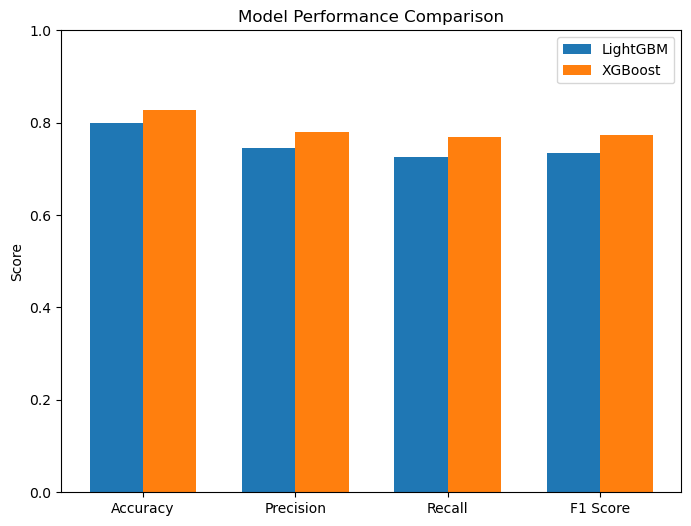

In [5]:
# Visualization
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
lgbm_scores = [lgbm_results[metric] for metric in metrics]
xgbm_scores = [xgbm_results[metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, lgbm_scores, width, label='LightGBM')
rects2 = ax.bar(x + width/2, xgbm_scores, width, label='XGBoost')

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, 1)
plt.show()